In [5]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sktime.datasets import load_from_tsfile_to_dataframe
import pandas as pd



In [2]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]

DATA_DIR = SRC_DIR / "data"
DATASET_DIR = DATA_DIR / "RefrigerationDevices"
train_path = DATASET_DIR / "RefrigerationDevices_TRAIN.ts"
test_path  = DATASET_DIR / "RefrigerationDevices_TEST.ts"


In [4]:
X_train, y_train = load_from_tsfile_to_dataframe(str(train_path))
X_test,  y_test  = load_from_tsfile_to_dataframe(str(test_path))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Example series shape:", X_train.iloc[0, 0].shape)

def df_to_numpy(X):
    arr = np.stack([X.iloc[i, 0] for i in range(len(X))], axis=0)
    return arr[..., np.newaxis]  # (N, T, 1)

X_train_np = df_to_numpy(X_train)
X_test_np  = df_to_numpy(X_test)

X_train shape: (375, 1)
X_test shape : (375, 1)
Example series shape: (720,)


In [6]:
N_train, T, C = X_train_np.shape
N_test,  T_test, C_test = X_test_np.shape
assert T == T_test and C == C_test == 1

print(f"Train: {N_train} séries, longueur T = {T}, C = {C}")
print(f"Test : {N_test} séries, longueur T = {T_test}, C = {C_test}")

y_train_np = y_train.astype(np.int64)
y_test_np  = y_test.astype(np.int64)

print("Labels train uniques:", np.unique(y_train_np))
print("Labels test  uniques:", np.unique(y_test_np))

CLASS_NAMES = {1: "Fridge/Freezer",2: "Refrigerator",3: "Upright Freezer",}



Train: 375 séries, longueur T = 720, C = 1
Test : 375 séries, longueur T = 720, C = 1
Labels train uniques: [1 2 3]
Labels test  uniques: [1 2 3]


## 2. Visualisation d'exemples par classe

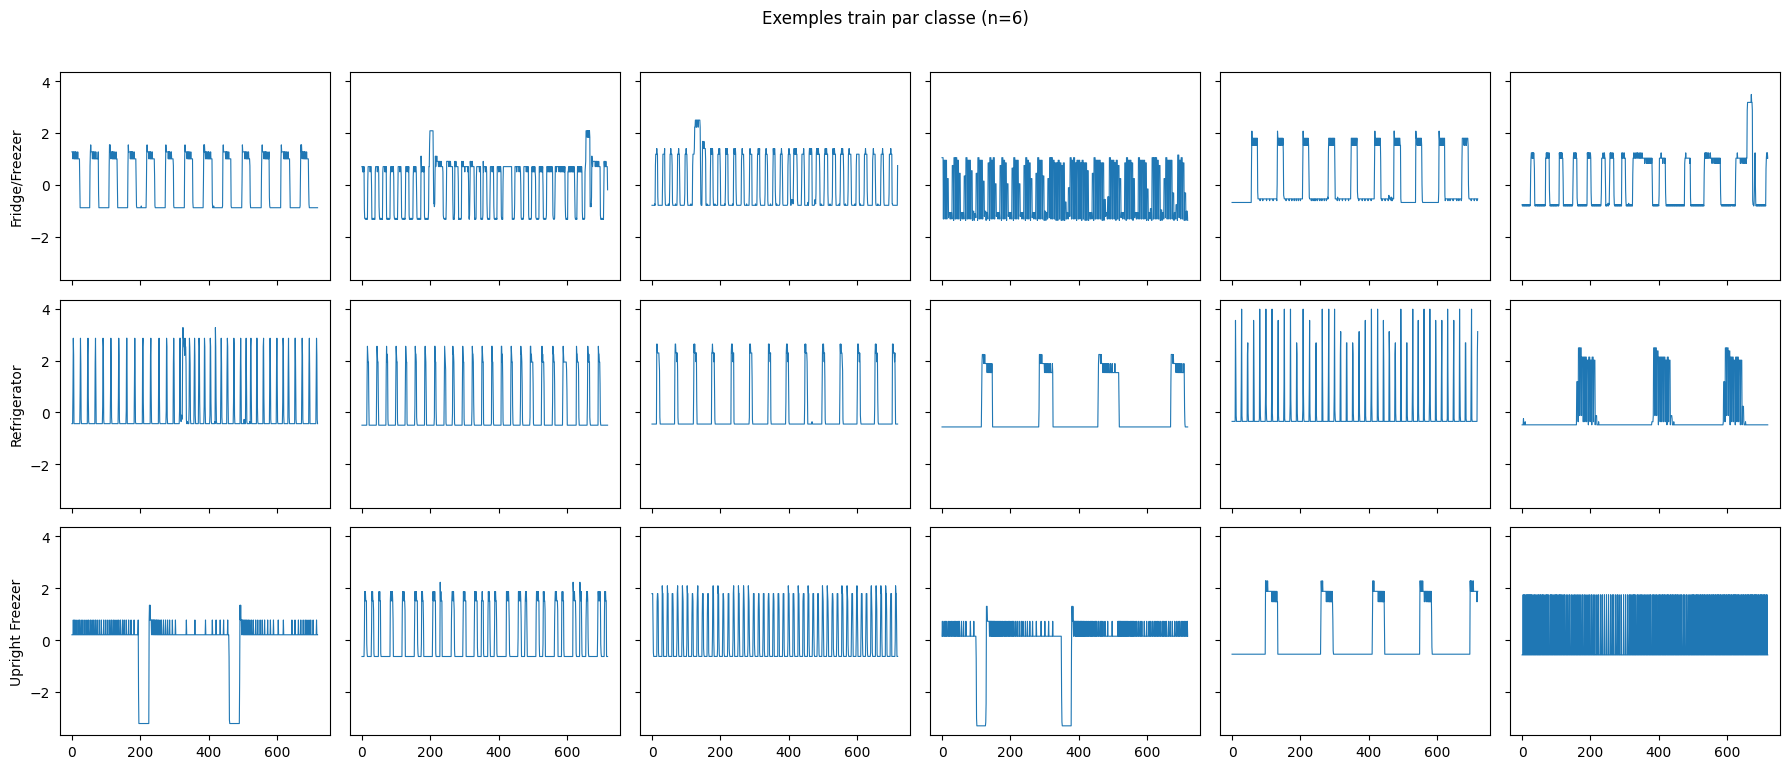

In [ ]:
rng = np.random.default_rng(0)

def plot_examples_by_class(X, y, class_names, n_per_class=5, split_name="train"):
    """
    X : (N, T, 1)
    y : (N,)
    """
    labels = sorted(class_names.keys())
    n_classes = len(labels)

    fig, axes = plt.subplots(
        n_classes, n_per_class,
        figsize=(3 * n_per_class, 2.5 * n_classes),
        sharex=True, sharey=True
    )

    if n_classes == 1:
        axes = np.expand_dims(axes, axis=0)
    if n_per_class == 1:
        axes = np.expand_dims(axes, axis=1)

    t = np.arange(X.shape[1])

    for row, lab in enumerate(labels):
        idxs = np.where(y == lab)[0]
        if len(idxs) == 0:
            continue
        chosen = rng.choice(idxs, size=min(n_per_class, len(idxs)), replace=False)

        for col, idx in enumerate(chosen):
            ax = axes[row, col]
            s = X[idx, :, 0]  # (T,)

            ax.plot(t, s, linewidth=0.8)
            if col == 0:
                ax.set_ylabel(class_names[lab])

    fig.suptitle(f"Exemples {split_name} par classe)", y=1.02)
    plt.tight_layout()

plot_examples_by_class(X_train_np, y_train_np, CLASS_NAMES, n_per_class=6, split_name="train")


## Détection d'outlier négatif.

In [21]:
# fonction qui renvoie les valeurs négatives minimale (identification du seuil OFF) pour chaque séries.
def estimate_off_baseline_hist(X,n_bins=30,min_neg_points=10,tail_ratio=0.02):
    # n_bins : nb de bins pour l'histogramme des valeurs négatives
    # min_neg_points: nb min de points négatifs pour estimer un OFF
    # tail_ratio  : fraction minimale de points en dessous du mode pour considérer qu'il y a une 'queue' à corriger
    N, T, C = X.shape
    baselines = np.zeros(N, dtype=np.float32)

    for i in range(N):
        x = X[i, :, 0]  # (T,)
        x_neg = x[x < 0]

        # Pas assez de négatifs , on ne fait rien
        if x_neg.size < min_neg_points:
            baselines[i] = x.min()
            continue

        # Histogramme sur les valeurs négatives
        hist, bin_edges = np.histogram(x_neg, bins=n_bins)

        # Bin le plus peuplé = plateau OFF typique
        k_mode = np.argmax(hist)
        mode_lower = bin_edges[k_mode]
        mode_upper = bin_edges[k_mode + 1]

        # Nombre de points en-dessous du plateau OFF
        n_tail = np.sum(x_neg < mode_lower)
        frac_tail = n_tail / x_neg.size

        if frac_tail < tail_ratio:
            # Pas de vraie queue négative, pas de nouvelle baseline
            baselines[i] = x.min()
        else:
            # Il y a une queue sous le mode , on clippe sous le plateau OFF
            baselines[i] = mode_lower
    return baselines


In [22]:
def clip_below_baseline_per_series(X, baselines):
    X_clip = X.copy()
    b = baselines[:, None, None]  # (N, 1, 1)
    X_clip = np.maximum(X_clip, b)
    return X_clip


In [ ]:
baseline_train = estimate_off_baseline_hist(X_train_np, n_bins=32, min_neg_points=20, tail_ratio=0.02)
baseline_test  = estimate_off_baseline_hist(X_test_np,  n_bins=32, min_neg_points=20, tail_ratio=0.02)

X_train_clip = clip_below_baseline_per_series(X_train_np, baseline_train)
X_test_clip  = clip_below_baseline_per_series(X_test_np,  baseline_test)

print("Quelques baselines train :", baseline_train[:10])


Quelques baselines train : [-0.8979441  -1.0301179  -0.8133552  -1.0603307  -1.390557   -0.5570254
 -0.69540656 -0.5324683  -0.7096701  -0.729212  ]


### MSE pour récupérer uniquement les séries les plus affectés par ce clipping

In [31]:
def compute_mse_per_series(X_before, X_after):
    """
    X_before, X_after : (N, T, 1)
    Retourne :
        mse : (N,) MSE par série
    """
    diff = X_before - X_after      # (N, T, 1)
    mse = np.mean(diff**2, axis=(1, 2))
    return mse

mse_train = compute_mse_per_series(X_train_np, X_train_clip)
mse_test = compute_mse_per_series(X_test_np,X_test_clip)

### affichage de ces séries les plus affectés

In [24]:
def show_top_modified_series(
    X_before, X_after, y, mse,
    class_names,
    top_k=10,
    split_name="train"
):
    """
    X_before, X_after : (N, T, 1)
    y : (N,)
    mse : (N,)
    class_names : dict {label -> nom}
    top_k : nb de séries à afficher
    """
    N, T, _ = X_before.shape
    top_k = min(top_k, N)

    # indices triés par MSE décroissante
    sorted_idx = np.argsort(-mse)
    top_idx = sorted_idx[:top_k]

    print(f"Top-{top_k} séries les plus modifiées par le clipping ({split_name}) :")
    for rank, idx in enumerate(top_idx, 1):
        lab = int(y[idx])
        cname = class_names.get(lab, str(lab))
        print(f"{rank:2d}) idx={idx:4d}, label={lab} ({cname}), MSE={mse[idx]:.6g}")

    # Visualisation
    t = np.arange(T)
    fig, axes = plt.subplots(top_k, 1, figsize=(10, 2.5 * top_k), sharex=True)
    if top_k == 1:
        axes = [axes]

    for ax, idx in zip(axes, top_idx):
        s_before = X_before[idx, :, 0]
        s_after  = X_after[idx, :, 0]
        lab = int(y[idx])
        cname = class_names.get(lab, str(lab))

        ax.plot(t, s_before, label="avant clipping", alpha=0.7)
        ax.plot(t, s_after,  label="après clipping", alpha=0.7)
        ax.set_title(
            f"idx={idx}, label={lab} ({cname}), MSE={mse[idx]:.4g}"
        )
        ax.legend()

    axes[-1].set_xlabel("timestamp")
    fig.suptitle(f"{split_name}: séries les plus affectées par le clipping", y=1.02)
    plt.tight_layout()

    return top_idx


Top-2 séries les plus modifiées par le clipping (train) :
 1) idx=  90, label=1 (Fridge/Freezer), MSE=0.615239
 2) idx=  91, label=1 (Fridge/Freezer), MSE=0.277222


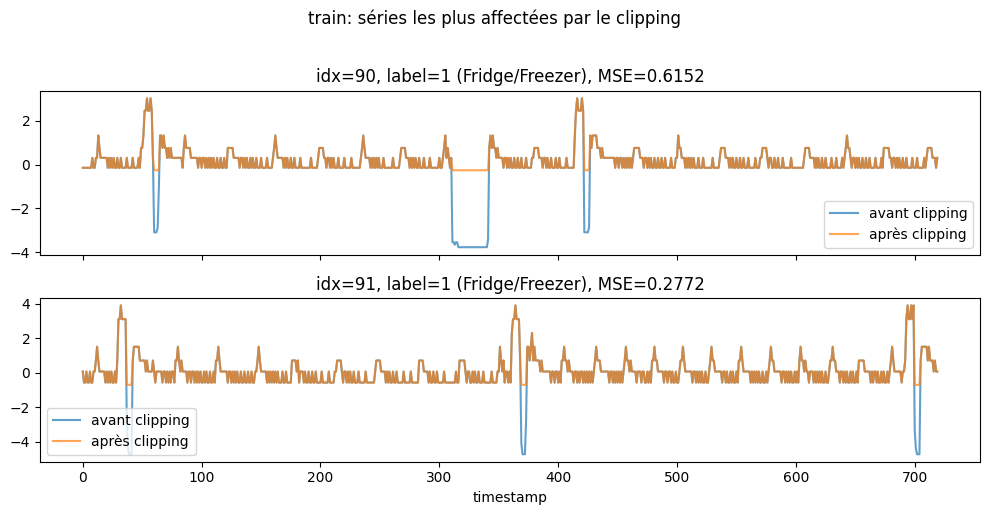

In [33]:

top_idx_train = show_top_modified_series(X_train_np, X_train_clip,y_train_np, mse_train,CLASS_NAMES,top_k=2,split_name="train")

Top-2 séries les plus modifiées par le clipping (test) :
 1) idx= 370, label=3 (Upright Freezer), MSE=0.0963264
 2) idx= 113, label=1 (Fridge/Freezer), MSE=0.00593551


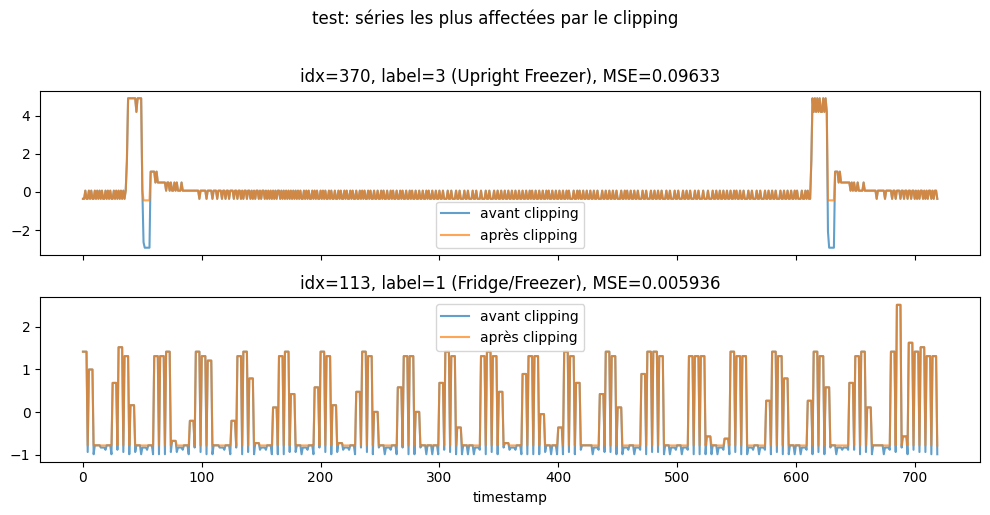

In [34]:

top_idx_test = show_top_modified_series(X_test_np, X_test_clip,y_test_np, mse_test,CLASS_NAMES,top_k=2,split_name="test")

## Série considéré sans sens physique, removed du train dataset

In [ ]:
def plot_given_indices(X, y, idxs, title=""):
    t = np.arange(X.shape[1])
    n = len(idxs)
    n_cols = min(4, n)
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 2.5 * n_rows),
        sharex=True, sharey=True
    )
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)

    for ax, idx in zip(axes.ravel(), idxs):
        s = X[idx, :, 0]
        ax.plot(t, s)
        lab = int(y[idx])
        ax.set_title(f"idx={idx}, class={CLASS_NAMES.get(lab, lab)}")

    for ax in axes.ravel()[len(idxs):]:
        ax.axis("off")

    fig.suptitle(title, y=1.02)
    plt.tight_layout()



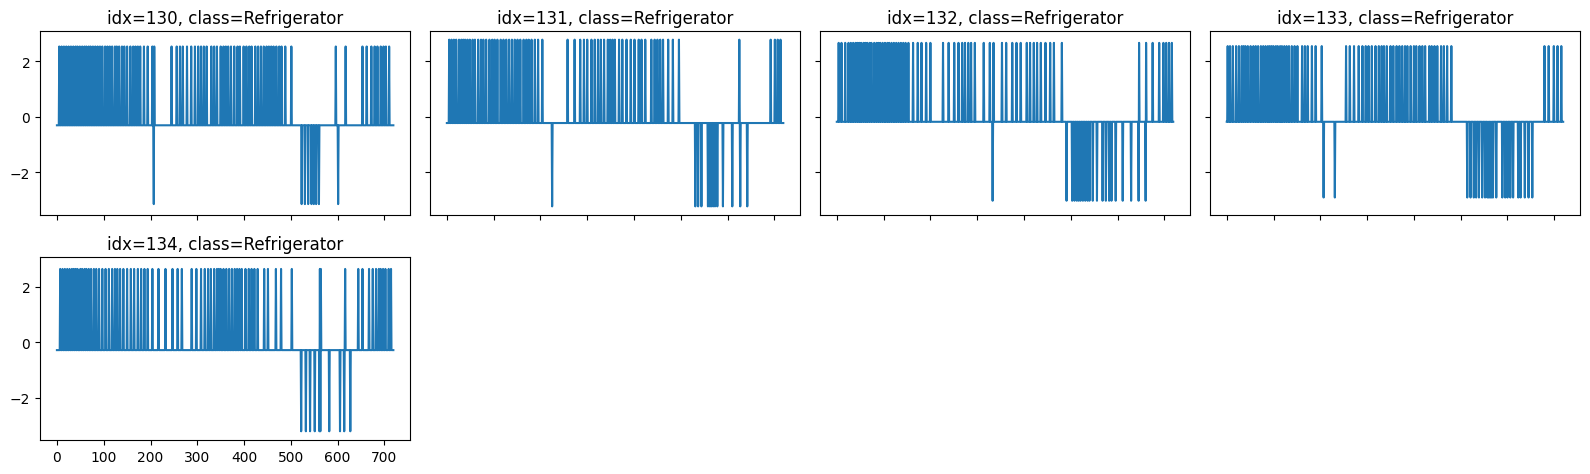

In [39]:
plot_given_indices(X_train_np,y_train_np,idxs=[130,131,132,133,134])

## Enregistrement du nouveau dataset

In [40]:
bad_idx = np.array([130, 131, 132, 133,134], dtype=int)

N_train = X_train_clip.shape[0]
mask_keep = np.ones(N_train, dtype=bool)
mask_keep[bad_idx] = False

X_train_clean = X_train_clip[mask_keep]  
y_train_clean = y_train_np[mask_keep]    

print("Train original :", X_train_clip.shape, y_train_np.shape)
print("Train clean :", X_train_clean.shape, y_train_clean.shape)
print("Test :", X_test_clip.shape, y_test_np.shape)


Train original : (375, 720, 1) (375,)
Train clean    : (370, 720, 1) (370,)
Test (inchangé): (375, 720, 1) (375,)


In [41]:
PREP_DIR = DATASET_DIR / "preprocessed"
PREP_DIR.mkdir(parents=True, exist_ok=True)

train_npz_path = PREP_DIR / "RefrigerationDevices_TRAIN_preprocessed.npz"
test_npz_path  = PREP_DIR / "RefrigerationDevices_TEST_preprocessed.npz"

np.savez_compressed(train_npz_path,X=X_train_clean,y=y_train_clean)
np.savez_compressed(test_npz_path,X=X_test_clip,y=y_test_np)

print("Saved train to :", train_npz_path)
print("Saved test  to :", test_npz_path)


Saved train to : /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/data/RefrigerationDevices/preprocessed/RefrigerationDevices_TRAIN_preprocessed.npz
Saved test  to : /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/data/RefrigerationDevices/preprocessed/RefrigerationDevices_TEST_preprocessed.npz
